In [24]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [25]:
from pandas import read_csv
from datetime import datetime

# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d')
dataset = read_csv('out.csv', index_col=0, delimiter=',', usecols = [i for i in range(3)])
x = dataset.isnull().sum()
print(x)
dataset.fillna(method='ffill', inplace=True)
x = dataset.isnull().sum()
print(x)
# print('här är antalet null: ' + dataset.isnull().sum())
#dataset['SPGTCLEN'] = [float(str(i).replace(',','')) for i in dataset['SPGTCLEN']]
#dataset.drop('No', axis = 1, inplace=True)

# manually specify column names
dataset.columns = ['open', 'oil']
dataset.index.name = 'date'

# mark all NA values with 0 (vi har inga tror jag?)
dataset.fillna(0, inplace=True)


# summarize first 2 rows
print(dataset.head(5))

# save to file
dataset.to_csv('past_returns.csv')

Clean      0
Oil      104
dtype: int64
Clean    0
Oil      0
dtype: int64
               open         oil
date                           
2011-03-31  1199.18  104.309998
2011-04-01  1199.06  106.620003
2011-04-04  1202.59  108.290001
2011-04-05  1195.90  108.199997
2011-04-06  1189.41  107.989998


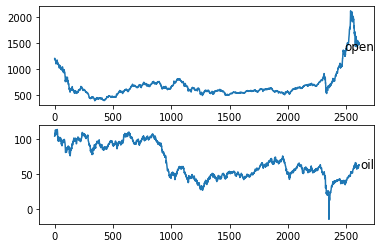

In [26]:
from pandas import read_csv
from matplotlib import pyplot

# load dataset
dataset = read_csv('past_returns.csv', header=0, index_col=0)
values = dataset.values

# specify colmuns to plot
groups = [0, 1]
i = 1

# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [27]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    #drop rows w NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('past_returns.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[2]], axis=1, inplace=True)
print(reframed.head())



   var1(t-1)  var2(t-1)   var2(t)
1   0.468682   0.945562  0.970574
2   0.468612   0.970574  0.986758
3   0.470663   0.986758  0.985777
4   0.466776   0.985777  0.984306
5   0.463005   0.984306  0.990191


In [29]:
# split into train and test sets
values = reframed.values
n_train_days = 365
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into inputs and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(365, 1, 2) (365,) (2246, 1, 2) (2246,)


Epoch 1/50
6/6 - 3s - loss: 0.8177 - val_loss: 0.4274
Epoch 2/50
6/6 - 0s - loss: 0.7808 - val_loss: 0.3992
Epoch 3/50
6/6 - 0s - loss: 0.7437 - val_loss: 0.3714
Epoch 4/50
6/6 - 0s - loss: 0.7059 - val_loss: 0.3442
Epoch 5/50
6/6 - 0s - loss: 0.6670 - val_loss: 0.3175
Epoch 6/50
6/6 - 0s - loss: 0.6267 - val_loss: 0.2912
Epoch 7/50
6/6 - 0s - loss: 0.5845 - val_loss: 0.2651
Epoch 8/50
6/6 - 0s - loss: 0.5399 - val_loss: 0.2402
Epoch 9/50
6/6 - 0s - loss: 0.4925 - val_loss: 0.2166
Epoch 10/50
6/6 - 0s - loss: 0.4418 - val_loss: 0.1954
Epoch 11/50
6/6 - 0s - loss: 0.3873 - val_loss: 0.1779
Epoch 12/50
6/6 - 0s - loss: 0.3285 - val_loss: 0.1662
Epoch 13/50
6/6 - 0s - loss: 0.2649 - val_loss: 0.1646
Epoch 14/50
6/6 - 0s - loss: 0.1961 - val_loss: 0.1724
Epoch 15/50
6/6 - 0s - loss: 0.1217 - val_loss: 0.1921
Epoch 16/50
6/6 - 0s - loss: 0.0614 - val_loss: 0.2182
Epoch 17/50
6/6 - 0s - loss: 0.0527 - val_loss: 0.2428
Epoch 18/50
6/6 - 0s - loss: 0.0661 - val_loss: 0.2480
Epoch 19/50
6/6 - 0

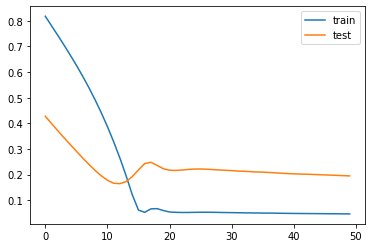

In [30]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [32]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1)) # 1
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(dataset['open'])
plt.plot(combine[['open', 'y_hat']])
plt.xlim([datetime.date(2020, 12, 1), datetime.date(2021, 4, 20)])
plt.legend(['Train', 'Val', 'Pred'], loc='lower right')


ValueError: in user code:

    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_6 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2)
